In [1]:
# Notebook support or argpase
import sys; sys.argv=['']; del sys

In [2]:
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import os
import copy
import json
import numpy as np
import matplotlib as mpl
import compress_pickle as cpkl

import rsatoolbox
from torchinfo import summary

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
# plt.style.use("seaborn-darkgrid")

import wandb

import models
from models import GW_Actor, GRU_Actor

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from ss_baselines.common.utils import plot_top_down_map


mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white" 

/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# General config related
from configurator import get_arg_dict, generate_args

# Env config related
from ss_baselines.av_nav.config import get_config
from ss_baselines.savi.config.default import get_config as get_savi_config
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class

# region: Generating additional hyparams
CUSTOM_ARGS = [
	# General hyper parameters
	get_arg_dict("seed", int, 111),
	get_arg_dict("total-steps", int, 1_000_000),

	# Behavior cloning gexperiment config
	get_arg_dict("dataset-path", str, "SAVI_Oracle_Dataset_v0"),

	# SS env config
	get_arg_dict("config-path", str, "env_configs/savi/savi_ss1_rgb_spectro.yaml"),

	# PPO Hyper parameters
	get_arg_dict("num-envs", int, 10), # Number of parallel envs. 10 by default
	get_arg_dict("num-steps", int, 150), # For each env, how many steps are collected to form PPO Agent rollout.
	get_arg_dict("num-minibatches", int, 1), # Number of mini-batches the rollout data is split into to make the updates
	get_arg_dict("update-epochs", int, 4), # Number of gradient step for the policy and value networks
	get_arg_dict("gamma", float, 0.99),
	get_arg_dict("gae-lambda", float, 0.95),
	get_arg_dict("norm-adv", bool, True, metatype="bool"),
	get_arg_dict("clip-coef", float, 0.1), # Surrogate loss clipping coefficient
	get_arg_dict("clip-vloss", bool, True, metatype="bool"),
	get_arg_dict("ent-coef", float, 0.2), # Entropy loss coef; 0.2 in SS baselines
	get_arg_dict("vf-coef", float, 0.5), # Value loss coefficient
	get_arg_dict("max-grad-norm", float, 0.5),
	get_arg_dict("target-kl", float, None),
	get_arg_dict("lr", float, 2.5e-4), # Learning rate
	get_arg_dict("optim-wd", float, 0), # weight decay for adam optim
	## Agent network params
	get_arg_dict("agent-type", str, "gw", metatype="choice",
		choices=["gw", "gru"]),
	get_arg_dict("gru-type", str, "layernorm", metatype="choice",
					choices=["default", "layernorm"]),
	get_arg_dict("hidden-size", int, 512), # Size of the visual / audio features

	## BC related hyper parameters
	get_arg_dict("batch-chunk-length", int, 0), # For gradient accumulation
	get_arg_dict("dataset-ce-weights", bool, False, metatype="bool"), # If True, will read CEL weights based on action dist. from the 'dataset_statistics.bz2' file.
	get_arg_dict("ce-weights", float, None, metatype="list"), # Weights for the Cross Entropy loss

	## GW Agent with custom attention, recurrent encoder and null inputs
	get_arg_dict("gw-size", int, 512), # Dim of the GW vector
	get_arg_dict("recenc-use-gw", bool, True, metatype="bool"), # Use GW at Recur. Enc. level
	get_arg_dict("recenc-gw-detach", bool, True, metatype="bool"), # When using GW at Recurrent Encoder level, whether to detach the grads or not
	get_arg_dict("gw-use-null", bool, True, metatype="bool"), # Use Null at CrossAtt level
	get_arg_dict("gw-cross-heads", int, 1), # num_heads of the CrossAttn

	# Probing setting
	get_arg_dict("probe-depth", int, 2),
	get_arg_dict("probe-hid-size", int, 512),
	get_arg_dict("probe-bias", bool, False, metatype="bool"),
	
	get_arg_dict("probing-targets", str, ["category", "scene"], metatype="list"), # What to probe for 
	get_arg_dict("probing-inputs", str, 
			["state_encoder", "visual_encoder.rnn", "audio_encoder.rnn"], metatype="list"), # What to base the probe on
	get_arg_dict("pretrained-model-name", str, None), # Simplified model name; required
	get_arg_dict("pretrained-model-path", str, None), # Path to the weights of the pre-trained model; required
	get_arg_dict("n-epochs", int, 1), # How many iteration over the whole dataset (* with caveat)

	# Eval protocol
	get_arg_dict("eval", bool, True, metatype="bool"),
	get_arg_dict("eval-every", int, int(1.5e4)), # Every X frames || steps sampled
	get_arg_dict("eval-n-episodes", int, 5),

	# Logging params
	# NOTE: Video logging expensive
	get_arg_dict("save-videos", bool, False, metatype="bool"),
	get_arg_dict("save-model", bool, True, metatype="bool"),
	get_arg_dict("save-model-every", int, int(5e5)), # Every X frames || steps sampled
	get_arg_dict("log-sampling-stats-every", int, int(1.5e3)), # Every X frames || steps sampled
	get_arg_dict("log-training-stats-every", int, int(10)), # Every X model update
	get_arg_dict("logdir-prefix", str, "./logs/") # Overrides the default one
]
args = generate_args(CUSTOM_ARGS)
# endregion: Generating additional hyparams

# Load environment config
is_SAVi = str.__contains__(args.config_path, "savi")
if is_SAVi:
	env_config = get_savi_config(config_paths=args.config_path)
else:
	env_config = get_config(config_paths=args.config_path)

## Instantiate obs / act space based on args and env_config

In [4]:
# Overriding some envs parametes from the .yaml env config
env_config.defrost()
env_config.NUM_PROCESSES = 1 # Corresponds to number of envs, makes script startup faster for debugs
env_config.USE_SYNC_VECENV = True
# env_config.USE_VECENV = False
# env_config.CONTINUOUS = args.env_continuous
## In caes video saving is enabled, make sure there is also the rgb videos
env_config.freeze()
# print(env_config)

# Environment instantiation
# envs = construct_envs(env_config, get_env_class(env_config.ENV_NAME))
# Dummy environment spaces

# TODO: add dyanmicallly set single_observation_space so that RGB and RGBD based variants
# can be evaluated at thet same time
from gym import spaces
single_action_space = spaces.Discrete(4)
single_observation_space = spaces.Dict({
    "rgb": spaces.Box(shape=[128,128,3], low=0, high=255, dtype=np.uint8),
    # "depth": spaces.Box(shape=[128,128,1], low=0, high=255, dtype=np.uint8),
    "audiogoal": spaces.Box(shape=[2,16000], low=-3.4028235e+38, high=3.4028235e+38, dtype=np.float32),
    "spectrogram": spaces.Box(shape=[65,26,2], low=-3.4028235e+38, high=3.4028235e+38, dtype=np.float32)
})
# single_observation_space = envs.observation_spaces[0]
# single_action_space = envs.action_spaces[0]

single_observation_space, single_action_space

(Dict(audiogoal:Box(-3.4028235e+38, 3.4028235e+38, (2, 16000), float32), rgb:Box(0, 255, (128, 128, 3), uint8), spectrogram:Box(-3.4028235e+38, 3.4028235e+38, (65, 26, 2), float32)),
 Discrete(4))

# Loading the Category-Scene-Trajs, Scene-Category-Trajs, and Dataset's metadata

### Loads data for analysis, as well as dataset's metadata

In [5]:
# Specify file name
analysis_trajs_filename = "cats_scenes_trajs_C_6_M_5_N_5__2023_06_01_10_41.bz2"

# Read the filtred trajectories data
## Default format is {cat -> { scenes -> traj: []}}
with open(analysis_trajs_filename, "rb") as f:
    cats_scenes_trajs_dict = cpkl.load(f)

## Compute the equivalent scenes cat trajs format
## {scenes -> { cat -> trajs: []}}
scenes_cats_trajs_dict = {}
for cat, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    for scene, scenes_trajs in cat_scenes_trajs.items():
        if scene not in scenes_cats_trajs_dict.keys():
            scenes_cats_trajs_dict[scene] = {}
        
        scenes_cats_trajs_dict[scene][cat] = scenes_trajs

# Generic: load the dataset statistics
## Compute action coefficient for CEL of BC
dataset_stats_filepath = f"{args.dataset_path}/dataset_statistics.bz2"
# Override dataset statistics if the file already exists
if os.path.exists(dataset_stats_filepath):
    with open(dataset_stats_filepath, "rb") as f:
        dataset_statistics = cpkl.load(f)

# Extract some global metadata
# TARGET_SCENE_LIST = list(cats_scenes_trajs_dict[list(cats_scenes_trajs_dict.keys())[0]].keys())
TARGET_SCENE_LIST = list(dataset_statistics["scene_counts"].keys())
TARGET_SCENE_DICT = {scene: i for i, scene in enumerate(TARGET_SCENE_LIST)}
TARGET_CATEGORY_LIST = list(cats_scenes_trajs_dict.keys())
TARGET_CATEGORY_DICT = {cat: i for i, cat in enumerate(TARGET_CATEGORY_LIST)}

from soundspaces.mp3d_utils import CATEGORY_INDEX_MAPPING
def get_category_name(idx):
    assert idx >= 0 and idx <=20, f"Invalid category index number: {idx}"

    for catname, catidx in CATEGORY_INDEX_MAPPING.items():
        if catidx == idx:
            return catname

def get_sceneid_by_idx(scene_idx):
    for k, v in TARGET_SCENE_DICT.items():
        if v == scene_idx:
            return k

C = len(TARGET_CATEGORY_LIST) # C: total number of categories
M = len(TARGET_SCENE_LIST) # M: total number of rooms, assuming all categories has N trajs for a same set of scenes.

print(f"# of categories C: {C} | # of scenes: {M}")
print(f"TARGET_CATEGORY_DICT: {TARGET_CATEGORY_DICT}")
print(f"TARGET_SCENE_DICT: {TARGET_SCENE_DICT}")
print("")

# for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
#     print(f"Cat: {catname}; Scenes: {[k for k in cat_scenes_trajs.keys()]}")

# Basic check of the scene -> categories fileted trajectories
# for scene, scenes_cat_trajs in scenes_cats_trajs_dict.items():
#     print(f"Scene: {scene}; Cats: {[k for k in scenes_cat_trajs.keys()]}")

# More detailed breakdown of the trajectories per categories then scenes
for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    print(f"{catname}:")
    for scene, scene_trajs in cat_scenes_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
        print(f"\t{scene}: {traj_lengths}")
    print("")

# More detailed breakdown of the trajectories per categories then scenes
for scene, scene_cats_trajs in scenes_cats_trajs_dict.items():
    print(f"{scene}")
    for cat, cat_trajs in scene_cats_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in cat_trajs]
        print(f"\t{cat}: {traj_lengths}")
    print("")

# of categories C: 6 | # of scenes: 56
TARGET_CATEGORY_DICT: {'chair': 0, 'picture': 1, 'table': 2, 'cushion': 3, 'cabinet': 4, 'plant': 5}
TARGET_SCENE_DICT: {'gTV8FGcVJC9': 0, '5LpN3gDmAk7': 1, 'vyrNrziPKCB': 2, 'b8cTxDM8gDG': 3, 'Vvot9Ly1tCj': 4, 'rPc6DW4iMge': 5, 'PuKPg4mmafe': 6, '759xd9YjKW5': 7, 'ZMojNkEp431': 8, 'VzqfbhrpDEA': 9, 'ac26ZMwG7aT': 10, 'D7N2EKCX4Sj': 11, 'E9uDoFAP3SH': 12, 'S9hNv5qa7GM': 13, '5q7pvUzZiYa': 14, 'kEZ7cmS4wCh': 15, 'VFuaQ6m2Qom': 16, '7y3sRwLe3Va': 17, 'p5wJjkQkbXX': 18, 'V2XKFyX4ASd': 19, 'VVfe2KiqLaN': 20, 'mJXqzFtmKg4': 21, 'SN83YJsR3w2': 22, 'EDJbREhghzL': 23, 'PX4nDJXEHrG': 24, 'JmbYfDe2QKZ': 25, 'r1Q1Z4BcV1o': 26, 'aayBHfsNo7d': 27, 'r47D5H71a5s': 28, 'pRbA3pwrgk9': 29, 'Pm6F8kyY3z2': 30, 'sKLMLpTHeUy': 31, 'GdvgFV5R1Z5': 32, 'e9zR4mvMWw7': 33, 'JeFG25nYj2p': 34, 'B6ByNegPMKs': 35, 'uNb9QFRL6hY': 36, 'cV4RVeZvu5T': 37, 'D7G3Y4RVNrH': 38, 'XcA2TqTSSAj': 39, 'ur6pFq6Qu1A': 40, '29hnd4uzFmX': 41, 's8pcmisQ38h': 42, 'qoiz87JEwZ2': 43, 'ULsKaCPVFJR':

## Helpers to extract traj. data based on "category", "scene", etc...

In [6]:
# region: Categories -> Scenes
## cats_scenes_trajs_dict: dictionary structured as: {category: {scene: [traj_data]}}
# TODO: add support for the device in case tensors are returned
def get_traj_data_by_category_scene_trajIdx(trajs_dicts, category, scene, trajIdx=0, tensorize=False, device="cpu"):
    # Get a single trajectory specified by idx, for a specificed category and scene
    # TODO: maybe fix the "depth" dimension here directly ?
    obs_list_dict = trajs_dicts[category][scene][trajIdx]["edd"]["obs_list"]
    done_list = trajs_dicts[category][scene][trajIdx]["edd"]["done_list"]

    obs_dict_list = []
    target_scene_idx_list, target_category_idx_list = [], []

    T = len(obs_list_dict["rgb"])
    for t in range(T):
        obs_dict_list.append({k: v[t] for k, v in obs_list_dict.items()})
        target_scene_idx_list.append(TARGET_SCENE_DICT[scene])
        target_category_idx_list.append(CATEGORY_INDEX_MAPPING[category])

    # Tensorize if required
    if tensorize:
        done_list__th = []
        obs_dict_list__th = []

        for t, (obs_dict, done) in enumerate(zip(obs_dict_list, done_list)):
            # done_list__th.append(th.Tensor(np.array([done])[None, :]))
            done_list__th.append(th.Tensor(np.array([done])).to(device)) # TODO: make sure that the deprecation warning stops showing up. Or always stay on current Torch version.
            tmp_dict = {}
            for k, v in obs_dict.items():
                if k == "depth":
                    v = np.array(v)[:, :, None] # From (H, W) -> (H, W, 1)
                tmp_dict[k] = th.Tensor(v)[None, :].to(device)
            
            obs_dict_list__th.append(tmp_dict)
        
        return obs_dict_list__th, done_list__th, target_scene_idx_list, target_category_idx_list

    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_category_scene(trajs_dicts, category, scene, max_scenes=0, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category and scene
    obs_dict_list, done_list = [], []
    target_scene_idx_list, target_category_idx_list = [], []

    N_SCENES = len(trajs_dicts[category][scene])
    res_n_scenes = N_SCENES if max_scenes <= 0 else max_scenes

    for i in range(N_SCENES):
        traj_obs_dict_list, traj_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_category_scene_trajIdx(trajs_dicts, category, scene, i, tensorize=tensorize, device=device)

        obs_dict_list.extend(traj_obs_dict_list)
        done_list.extend(traj_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)

        traj_length = len(traj_done_list)
        # print(f"Selected traj of length: {traj_length}")
        if i >= res_n_scenes - 1:
            break

    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_category(trajs_dicts, category, max_scenes=0, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category, across all scenes and all trajectories
    obs_dict_list, done_list =[], []
    target_scene_idx_list, target_category_idx_list = [], []

    for scene in trajs_dicts[category].keys():
        scene_obs_dict_list, scene_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_category_scene(trajs_dicts, category, scene, max_scenes=max_scenes, tensorize=tensorize, device=device)

        obs_dict_list.extend(scene_obs_dict_list)
        done_list.extend(scene_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)
    
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_all_traj_data_by_category(trajs_dicts, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category, across all scenes and all trajectories
    obs_dict_list, done_list =[], []
    target_scene_idx_list, target_category_idx_list = [], []

    for cat in trajs_dicts.keys():
        cat_scene_obs_dict_list, cat_scene_done_list, cat_target_scene_idxes, cat_target_category_idxes = \
            get_traj_data_by_category(trajs_dicts, cat, tensorize=tensorize, device=device)

        obs_dict_list.extend(cat_scene_obs_dict_list)
        done_list.extend(cat_scene_done_list)
        target_scene_idx_list.extend(cat_target_scene_idxes)
        target_category_idx_list.extend(cat_target_category_idxes)
    
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list
# endregion: Categories -> Scenes


# region: Scenes -> Categories
# TODO: add "return" for target categories and scenes label
## scenes_cats_trajs_dict: dictionary structured as: {scene: {category: [traj-data]}}
def get_traj_data_by_scene_category_trajIdx(trajs_dicts, scene, category, trajIdx=0, tensorize=False, device="cpu"):
    # Get a single trajectory specified by idx, for a specificed category and scene
    # TODO: maybe fix the "depth" dimension here directly ?
    obs_list_dict = trajs_dicts[scene][category][trajIdx]["edd"]["obs_list"]
    done_list = trajs_dicts[scene][category][trajIdx]["edd"]["done_list"]
    target_scene_idx_list, target_category_idx_list = [], []

    obs_dict_list = []
    T = len(obs_list_dict["rgb"])
    for t in range(T):
        obs_dict_list.append({k: v[t] for k, v in obs_list_dict.items()})
        target_scene_idx_list.append(TARGET_SCENE_DICT[scene])
        target_category_idx_list.append(CATEGORY_INDEX_MAPPING[category])

    # Tensorize if required
    if tensorize:
        done_list__th = []
        obs_dict_list__th = []

        for t, (obs_dict, done) in enumerate(zip(obs_dict_list, done_list)):
            # done_list__th.append(th.Tensor(np.array([done])[None, :]))
            done_list__th.append(th.Tensor(np.array([done])).to(device)) # TODO: make sure that the deprecation warning stops showing up. Or always stay on current Torch version.
            tmp_dict = {}
            for k, v in obs_dict.items():
                if k == "depth":
                    v = np.array(v)[:, :, None] # From (H, W) -> (H, W, 1)
                tmp_dict[k] = th.Tensor(v)[None, :].to(device)
            
            obs_dict_list__th.append(tmp_dict)
        
        return obs_dict_list__th, done_list__th, target_scene_idx_list, target_category_idx_list
        
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_scene_category(trajs_dicts, scene, category, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category and scene
    obs_dict_list, done_list = [], []
    target_scene_idx_list, target_category_idx_list = [], []

    for i in range(len(trajs_dicts[scene][category])):
        traj_obs_dict_list, traj_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_scene_category_trajIdx(trajs_dicts, scene, category, i, tensorize=tensorize, device=device)

        obs_dict_list.extend(traj_obs_dict_list)
        done_list.extend(traj_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)

        traj_length = len(traj_done_list)
        # print(f"Selected traj of length: {traj_length}")

    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_scene(trajs_dicts, scene, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category, across all scenes and all trajectories
    obs_dict_list, done_list =[], []
    target_scene_idx_list, target_category_idx_list = [], []
    
    for cat in trajs_dicts[scene].keys():
        cat_obs_dict_list, cat_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_scene_category(trajs_dicts, scene, cat, tensorize=tensorize, device=device)

        obs_dict_list.extend(cat_obs_dict_list)
        done_list.extend(cat_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)
    
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_all_traj_data_by_scene(trajs_dicts, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category, across all scenes and all trajectories
    obs_dict_list, done_list =[], []
    target_scene_idx_list, target_category_idx_list = [], []

    for scene in trajs_dicts.keys():
        # Too rushing / lazy to change the names of the temporary list of obs
        cat_scene_obs_dict_list, cat_scene_done_list, cat_target_scene_idxes, cat_target_category_idxes = \
            get_traj_data_by_category(trajs_dicts, scene, tensorize=tensorize, device=device)

        obs_dict_list.extend(cat_scene_obs_dict_list)
        done_list.extend(cat_scene_done_list)
        target_scene_idx_list.extend(cat_target_scene_idxes)
        target_category_idx_list.extend(cat_target_category_idxes)
    
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list
# endregion: Scenes -> Categories

## Loading up agent weights for each experiment, and their probe weights.

In [ ]:
# workaround for Vscode / Jupyter not picking up env variables. Don't leak your key though.
%env WANDB_API_KEY

In [15]:
# Programmatically all the experiment runs, as well as their corresponding probing runs.
## Consts
WANDB_DL_PREFIX = "wandb_api_dls"

## Placeholder for the run restuls
REVISED_RUNS_DICT = {}

## Read the list of probing runs first, and build a correspondance map
## from original experimtn to probing runs
# TODO TODO TODO: change the source of probing runs
# revised_probing_runs = wandb.Api().runs("dosssman/ss-hab-bc-revised-finals-probing"); revised_probing_runs # (iterable) list
# NOTE: tmp source, while waiting for fixed runs to finish up
revised_probing_runs = wandb.Api().runs("dosssman/ss-hab-bc-revised-finals-probing"); revised_probing_runs # (iterable) list
final_to_probing_runs_dict = {}

for idx, probing_run in enumerate(revised_probing_runs):
  ## Recover some config attribute from the run, make a name for it
  ## Shared with the orignal agent experiment
  agent_type = probing_run.config["agent_type"]
  gw_size = probing_run.config["gw_size"]
  seed = probing_run.config["seed"] # NOTE: seed of the probing run, not the original run.
  exp_name = probing_run.config["exp_name"]
  pretrained_model_path = probing_run.config["pretrained_model_path"]
  original_exp_run = pretrained_model_path.split('/')[-3]

  original_exp_seed = exp_name.split("__")[-1].split("_")[-1]

  ## This refers to the run name of the revised experiment itself,
  ## not the probing
  run_name = f"ppo_bc__{agent_type}_{gw_size}__seed_{original_exp_seed}"

  # Download the output log which should have the final experiment name
  # If the run is not completed, there will not be an output.log file.
  unfinished_run_workaround = {
    "ppo_bc__gw_64__seed_3": "ppo_bc__gw_64__seed_3_seed_42__2024_03_26_16_55_15_051658.Valkyrie",
    "ppo_bc__gru_64__seed_3": "ppo_bc__gru_64__seed_3_seed_42__2024_03_26_16_55_01_236064.Valkyrie"
  }

  if run_name in list(unfinished_run_workaround.keys()):
    updated_exp_name = unfinished_run_workaround[run_name]
    exp_logdir_path = f"/home/rousslan/random/rl/exp-logs/ss-hab-bc-revised-finals-probing-fix/{unfinished_run_workaround[run_name]}"
  else:
    # Extracted from Wandb API list, but it requires the runs to be completed
    output_save_folder = f"{WANDB_DL_PREFIX}/probing/{run_name}"
    # print(run_name)
    # print(list(probing_run.files()))
    list(probing_run.files("output.log"))[0].download(output_save_folder, exist_ok=True)

    with open(f"{output_save_folder}/output.log", 'r') as f:
      # Extract the folder where the experimetns results and weights
      # were ultimately saved in
      exp_logdir_path = f.readlines()[2].replace("# Logdir: ", "")

      exp_logdir_path = exp_logdir_path.replace("\n", "") # Get rid of return to line char
      updated_exp_name = exp_logdir_path.split('/')[-1]
    
  # print(f"{original_exp_run} -> {updated_exp_name}")
  # TODO: also extract the path for the probing run model

  # pretrained_model_path = probing_run.config["pretrained_model_path"]
  # original_exp_run = pretrained_model_path.split('/')[-3] # Get the folder of the revised run experiment

  # final_to_probing_runs_dict[original_exp_run] = f"{updated_exp_name}" # DBG
  final_to_probing_runs_dict[original_exp_run] = f"{exp_logdir_path}"
  # if idx > 10:
  #   break

# print(len(list(final_to_probing_runs_dict.keys())))
print(json.dumps(final_to_probing_runs_dict, indent=2))

{
  "ppo_bc_seed_2__2024_03_01_16_41_13_154880.Loki": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-revised-finals-probing-fix/ppo_bc__gw_512__seed_2_seed_42__2024_03_26_20_03_58_381033.conan",
  "ppo_bc_seed_1__2024_02_25_18_38_15_313181.Loki": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-revised-finals-probing-fix/ppo_bc__gw_512__seed_1_seed_42__2024_03_26_20_03_58_426595.conan",
  "ppo_bc_seed_5__2024_03_01_07_19_24_810423.Loki": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-revised-finals-probing-fix/ppo_bc__gw_256__seed_5_seed_42__2024_03_26_20_03_58_435150.conan",
  "ppo_bc_seed_3__2024_03_06_00_19_57_042533.Loki": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-revised-finals-probing-fix/ppo_bc__gw_512__seed_3_seed_42__2024_03_26_17_09_36_811227.musashi",
  "ppo_bc_seed_5__2024_03_10_14_14_31_812251.Loki": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-revised-finals-probing-fix/ppo_bc__gw_512__seed_5_seed_42__2024_03_26_17_09_36_778678.musashi",
  "ppo_bc_seed_4__2024_03_06_10_06_25_8

In [16]:
## Read the list of runs
revised_exp_runs = wandb.Api().runs("dosssman/ss-hab-bc-revised-finals"); revised_exp_runs # (iterable) list

for idx, revised_run in enumerate(list(revised_exp_runs)[::-1]):
  ## Recover some config attribute from the run, make a name for it
  agent_type = revised_run.config["agent_type"]
  gw_size = revised_run.config["gw_size"]
  seed = revised_run.config["seed"]
  exp_name = revised_run.config["exp_name"]

  run_name = f"ppo_bc__{agent_type}_{gw_size}__seed_{seed}"

  # print(f"Processing idx {idx:2d}: {run_name}")

  # Download the output log which should have the final experiment name
  output_save_folder = f"{WANDB_DL_PREFIX}/{run_name}"
  list(revised_run.files("output.log"))[0].download(output_save_folder, exist_ok=True)

  with open(f"{output_save_folder}/output.log", 'r') as f:
    # Extract the folder where the experimetns results and weights
    # were ultimately saved in
    if run_name in [
      "ppo_bc__gw_128__seed_1",
      "ppo_bc__gru_128__seed_4"]:
      # Special cases where the log does not have the same length as the others
      exp_logdir_path = f.readlines()[0].replace("# Logdir: ", "")
    else:
      exp_logdir_path = f.readlines()[2].replace("# Logdir: ", "")
    exp_logdir_path = exp_logdir_path.replace("\n", "") # Get rid of return to line char
    updated_exp_name = exp_logdir_path.split('/')[-1]
    # TODO: also extract the path for the probing run model
  
  REVISED_RUNS_DICT[run_name] = {
    "pretty_name": f"{agent_type.upper()} {gw_size} [{seed}]",
    "state_dict_path": f"{exp_logdir_path}/models/ppo_agent.20001000.ckpt.pth", # For final use
    # "state_dict_path": f"{updated_exp_name}", # TODO: add the full path
    "probe_path": final_to_probing_runs_dict[updated_exp_name],
    "gw_size": gw_size,
    "agent_type": agent_type
  }

  # if idx > 5:
  #   break

print(json.dumps(REVISED_RUNS_DICT, indent=2))

{
  "ppo_bc__gw_32__seed_1": {
    "pretty_name": "GW 32 [1]",
    "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-revised-final/ppo_bc_seed_1__2024_02_13_10_37_37_585583.Loki/models/ppo_agent.20001000.ckpt.pth",
    "probe_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-revised-finals-probing-fix/ppo_bc__gw_32__seed_1_seed_42__2024_03_26_16_55_14_833835.Valkyrie",
    "gw_size": 32,
    "agent_type": "gw"
  },
  "ppo_bc__gw_64__seed_1": {
    "pretty_name": "GW 64 [1]",
    "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-revised-final/ppo_bc_seed_1__2024_02_13_10_37_42_215535.Loki/models/ppo_agent.20001000.ckpt.pth",
    "probe_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-revised-finals-probing-fix/ppo_bc__gw_64__seed_1_seed_42__2024_03_26_16_55_15_610022.Valkyrie",
    "gw_size": 64,
    "agent_type": "gw"
  },
  "ppo_bc__gw_128__seed_1": {
    "pretty_name": "GW 128 [1]",
    "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-r

In [22]:
# Loading pretrained agent
MODEL_VARIANTS_TO_STATEDICT_PATH = {
    ## GRU
    # region: SAVI BC GRUv3 variants: rec enc gw3 detach
    "ppo_bc__sweep_gru_512": {
        "pretty_name": "GRU 1 (Sweep)",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-revised-sweep/"
            "ppo_bc_seed_42__2024_02_05_18_30_00_569723.musashi"
            # "/models/ppo_agent.19995001.ckpt.pth",
            "/models/ppo_agent.10000500.ckpt.pth",
        # TODO: prending probes
        "probe_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-probing/"
            "ppo_bc__savi_ss1_rgb_spectro__gruv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__n_mb_50__prb_dpth_2_seed_111__2023_11_16_16_08_52_068321.conan"
    },
    # endregion: SAVI BC GRUv3 variants: rec enc gw3 detach

    ## GWTv3 H=512
    # region: SAVI BC GWTv3 variants: rec enc gw3 detach; CA uses null
    "ppo_bc__sweep_gw_64": {
        "pretty_name": "GW 1 (Sweep)",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-revised-sweep/"
            "ppo_bc_seed_42__2024_01_23_15_44_57_777702.musashi"
            "/models/ppo_agent.10000500.ckpt.pth",
        # TODO: prending probes
        "probe_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc-probing/"
            "ppo_bc__savi_ss1_rgb_spectro__gwtv3__gw_detach__usenull__grulynrm__entcoef_0.2__no_cew__n_mb_50__prb_dpth_2_seed_111__2023_11_14_18_38_49_687853.musashi"
    },
    # endregion: SAVI BC GWTv3 variants: rec enc gw3 detach; CA uses null
}

# Overrdie with systematically generated dict with agent and probes paths
MODEL_VARIANTS_TO_STATEDICT_PATH = REVISED_RUNS_DICT

# dev = th.device("cpu")
dev = th.device("cuda")

# 'variant named' indexed 'torch agent'
MODEL_VARIANTS_TO_AGENTMODEL = {}

for k, v in MODEL_VARIANTS_TO_STATEDICT_PATH.items():
    args_copy = copy.copy(args)
    tmp_args = copy.copy(args)

    # Recover GW size used for the agent
    tmp_args.gw_size = v["gw_size"]

    # Override args depending on the model in use
    if k.__contains__("gru"):
        print(f"Loaded GRU Agent: '{k}'")
        # print(f"  Feat size: {tmp_args.hidden_size}")
        print(f"  GW size: {tmp_args.gw_size}")

        agent = GRU_Actor(single_observation_space, single_action_space, tmp_args,
            analysis_layers=models.GWTAGENT_DEFAULT_ANALYSIS_LAYER_NAMES)
        # print(agent)
    elif k.__contains__("gw"):
        print(f"Loaded GW Agent: '{k}'")
        # print(f"  Feat size: {tmp_args.hidden_size}")
        print(f"  GW size: {tmp_args.gw_size}")

        agent = GW_Actor(single_observation_space, single_action_space, tmp_args,
            analysis_layers=models.GWTAGENT_DEFAULT_ANALYSIS_LAYER_NAMES + ["state_encoder.ca.mha"])
        # print(agent)

    agent.eval()
    # Load the model weights
    # TODO: add map location device to use CPU only ?
    if v["state_dict_path"] != "":
        agent_state_dict = th.load(v["state_dict_path"], map_location=dev)
        agent.load_state_dict(agent_state_dict)
    agent = agent.to(dev)

    MODEL_VARIANTS_TO_AGENTMODEL[k] = agent

Loaded GW Agent: 'ppo_bc__gw_32__seed_1'
  GW size: 32
Loaded GW Agent: 'ppo_bc__gw_64__seed_1'
  GW size: 64
Loaded GW Agent: 'ppo_bc__gw_128__seed_1'
  GW size: 128
Loaded GW Agent: 'ppo_bc__gw_256__seed_1'
  GW size: 256
Loaded GRU Agent: 'ppo_bc__gru_32__seed_2'
  GW size: 32
Loaded GRU Agent: 'ppo_bc__gru_64__seed_2'
  GW size: 64
Loaded GRU Agent: 'ppo_bc__gru_128__seed_2'
  GW size: 128
Loaded GW Agent: 'ppo_bc__gw_128__seed_2'
  GW size: 128
Loaded GW Agent: 'ppo_bc__gw_32__seed_2'
  GW size: 32
Loaded GW Agent: 'ppo_bc__gw_256__seed_2'
  GW size: 256
Loaded GW Agent: 'ppo_bc__gw_64__seed_4'
  GW size: 64
Loaded GRU Agent: 'ppo_bc__gru_32__seed_3'
  GW size: 32
Loaded GRU Agent: 'ppo_bc__gru_128__seed_3'
  GW size: 128
Loaded GRU Agent: 'ppo_bc__gru_64__seed_3'
  GW size: 64
Loaded GW Agent: 'ppo_bc__gw_256__seed_3'
  GW size: 256
Loaded GW Agent: 'ppo_bc__gw_32__seed_3'
  GW size: 32
Loaded GW Agent: 'ppo_bc__gw_128__seed_3'
  GW size: 128
Loaded GW Agent: 'ppo_bc__gw_64__seed

In [23]:
print(agent)

GRU_Actor(
  (visual_encoder): RecurrentVisualEncoder(
    (cnn): Sequential(
      (0): Conv2d(3, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
      (5): ReLU(inplace=True)
      (6): Flatten()
    )
    (rnn): GRUCell(
      (_layer): Linear(in_features=2848, out_features=1536, bias=True)
      (_norm): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
    )
  )
  (audio_encoder): RecurrentAudioEncoder(
    (cnn): Sequential(
      (0): Conv2d(2, 32, kernel_size=(5, 5), stride=(2, 2))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU(inplace=True)
      (6): Flatten()
    )
    (rnn): GRUCell(
      (_layer): Linear(in_features=3040, out_features=1536, bias=Tru

# Process agents features, retain the relevant ones

In [46]:
## Load the subset of cached features that will be analyzed
# CACHE_DIRNAME = "cats_scenes_trajs_C_6_M_5_N_5__2023_06_01_10_41__ablation_agents_features__cache"
# FEATURES_CACHE_DIRNAME = f"cached_data/features/cats_scenes_trajs_C_6_M_5_N_5__2023_06_01_10_41"

CATEGORIES_OF_INTEREST = [
    "chair",
    # "picture",
    # "cabinet",
    # "plant",
    # "cushion",
    # "table"
]
SCENES_OF_INTEREST = [
    "gTV8FGcVJC9",
    # "D7N2EKCX4Sj",
    # "b8cTxDM8gDG",
    # "Vvot9Ly1tCj",
    # "vyrNrziPKCB"
] # ['gTV8FGcVJC9', 'b8cTxDM8gDG', 'D7N2EKCX4Sj', 'Vvot9Ly1tCj', 'vyrNrziPKCB']
TRAJ_INDICES = [
    0,
    1,
    2,
    3,
    4
] # Only select trajectories in indices of interest
ABLATIONS_OF_INTEREST = ["default", "vision", "audio", "zeros"]
LAYERS_OF_INTEREST = [
    "visual_encoder.rnn", "audio_encoder.rnn",
    "state_encoder",
    "state_encoder.ca.mha", "state_encoder.ca"
]
AGENTS_OF_INTEREST = [
    # GW
    ## GW 32
    "ppo_bc__gw_32__seed_1",
    "ppo_bc__gw_32__seed_2",
    "ppo_bc__gw_32__seed_3",
    "ppo_bc__gw_32__seed_4",
    "ppo_bc__gw_32__seed_5",

    ## GW 64
    "ppo_bc__gw_64__seed_1",
    "ppo_bc__gw_64__seed_2",
    "ppo_bc__gw_64__seed_3",
    "ppo_bc__gw_64__seed_4",
    "ppo_bc__gw_64__seed_5",

    ## GW 128
    "ppo_bc__gw_128__seed_1",
    "ppo_bc__gw_128__seed_2",
    "ppo_bc__gw_128__seed_3",
    "ppo_bc__gw_128__seed_4",
    "ppo_bc__gw_128__seed_5",

    ## GW 256
    "ppo_bc__gw_256__seed_1",
    "ppo_bc__gw_256__seed_2",
    "ppo_bc__gw_256__seed_3",
    "ppo_bc__gw_256__seed_4",
    "ppo_bc__gw_256__seed_5",

    ## GW 512
    "ppo_bc__gw_512__seed_1",
    "ppo_bc__gw_512__seed_2",
    "ppo_bc__gw_512__seed_3",
    "ppo_bc__gw_512__seed_4",
    "ppo_bc__gw_512__seed_5",


    # GRU
    ## GRU 32
    "ppo_bc__gru_32__seed_1",
    "ppo_bc__gru_32__seed_2",
    "ppo_bc__gru_32__seed_3",
    "ppo_bc__gru_32__seed_4",
    "ppo_bc__gru_32__seed_5",

    ## GRU 64
    "ppo_bc__gru_64__seed_1",
    "ppo_bc__gru_64__seed_2",
    "ppo_bc__gru_64__seed_3",
    "ppo_bc__gru_64__seed_4",
    "ppo_bc__gru_64__seed_5",

    ## GRU 128
    "ppo_bc__gru_128__seed_1",
    "ppo_bc__gru_128__seed_2",
    "ppo_bc__gru_128__seed_3",
    "ppo_bc__gru_128__seed_4",
    "ppo_bc__gru_128__seed_5",

    ## GRU 256
    "ppo_bc__gru_256__seed_1",
    "ppo_bc__gru_256__seed_2",
    "ppo_bc__gru_256__seed_3",
    "ppo_bc__gru_256__seed_4",
    "ppo_bc__gru_256__seed_5",

    ## GRU 512
    "ppo_bc__gru_512__seed_1",
    "ppo_bc__gru_512__seed_2",
    "ppo_bc__gru_512__seed_3",
    "ppo_bc__gru_512__seed_4",
    "ppo_bc__gru_512__seed_5",
]

## Collect visual, audio, state features for all agent variants

In [47]:
# Collect the relevant features from the PGWT variants
CAT_SCENE_TRAJS_FEATURES = {}

## Helper for cleaning up and preparing the recorded intermediate features
def process_analysis_feats_raw__occ_variant(raw_dict):
    result_dict = {}

    for k, v in raw_dict.items():
        if isinstance(v[0], th.Tensor):
            new_v = th.stack(v, dim=0).cpu()
        elif isinstance(v[0], tuple):
            new_v = None # TODO
            n_elements = len(v[0])
            elements = [[] for _ in range(n_elements)]
            for j in range(n_elements):
                for i in range(len(v)):
                    elements[j].append(v[i][j])
            
            new_v = [th.stack(vv, dim=0).cpu() for vv in elements]
        else:
            raise Exception(f"Unhandled type: {v[0].__class__}")

        result_dict[k] = new_v

    return result_dict

for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    if catname not in CATEGORIES_OF_INTEREST:
        continue

    if catname not in CAT_SCENE_TRAJS_FEATURES.keys():
        CAT_SCENE_TRAJS_FEATURES[catname] = {}
    print(f"{catname}:")

    for scene, scene_trajs in cat_scenes_trajs.items():
        if scene not in SCENES_OF_INTEREST:
            continue

        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
        print(f"  {scene}: {traj_lengths}")

        if scene not in CAT_SCENE_TRAJS_FEATURES[catname].keys():
            CAT_SCENE_TRAJS_FEATURES[catname][scene] = {}
        
        for traj_idx, traj_data in enumerate(scene_trajs):
            if traj_idx not in TRAJ_INDICES:
                continue
            
            if traj_idx not in CAT_SCENE_TRAJS_FEATURES[catname][scene].keys():
                CAT_SCENE_TRAJS_FEATURES[catname][scene][traj_idx] = {}

            # Load the data, perform ablations if necessary
            obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list = \
                get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, catname, scene, traj_idx, tensorize=True, device=dev)
            
            ep_length = len(obs_dict_list)
            print(f"    Traj {traj_idx}: Length: {ep_length}")

            # TODO: verify
            CAT_SCENE_TRAJS_FEATURES[catname][scene][traj_idx]["target_scene_idx_list"] = target_scene_idx_list
            CAT_SCENE_TRAJS_FEATURES[catname][scene][traj_idx]["target_category_idx_list"] = target_category_idx_list

            for agent_variant, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
                if agent_variant not in AGENTS_OF_INTEREST:
                    continue
                print(f"        Model variant: {agent_variant}")

                agent_raw_features = {}
                # Init the agent_rnn_state depending on the variant used
                H = 512
                for gw_size in [32, 64, 128, 256]:
                    if agent_variant.__contains__(f"{gw_size}"):
                        H = gw_size

                print(f"          Detected GW size: {H}")

                agent_rnn_state = th.zeros((1, H), device=dev)
                modality_features = {
                    "audio": agent_rnn_state.new_zeros([1, 512]),
                    "visual": agent_rnn_state.new_zeros([1, 512])
                }
                
                for t, (obs_th, done_th) in enumerate(zip(obs_dict_list, done_list)):
                    
                    masks = 1. - done_th[:, None]
                    with th.no_grad():
                        _, _, _, _, \
                        _, agent_rnn_state, modality_features = \
                            agent_model.act(obs_th, agent_rnn_state, masks=masks, 
                                modality_features=modality_features)

                    # Collecting intermediate layers results
                    for k, v in agent_model._features.items():
                        if k not in LAYERS_OF_INTEREST:
                            continue # Skip irrelevant layers
                        if k not in list(agent_raw_features.keys()):
                            agent_raw_features[k] = []
                        agent_raw_features[k].append((v[0].cpu(), v[1].cpu()) if isinstance(v, tuple) else v.cpu())
                
                agent_layers_features = process_analysis_feats_raw__occ_variant(agent_raw_features)
                del agent_raw_features

                CAT_SCENE_TRAJS_FEATURES[catname][scene][traj_idx][agent_variant] = \
                    agent_layers_features
                
                # Caching features: TODO

            del obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

chair:
  gTV8FGcVJC9: [28, 10, 46, 9, 6]
    Traj 0: Length: 28
        Model variant: ppo_bc__gw_32__seed_1
          Detected GW size: 32
        Model variant: ppo_bc__gw_64__seed_1
          Detected GW size: 64
        Model variant: ppo_bc__gw_128__seed_1
          Detected GW size: 128
        Model variant: ppo_bc__gw_256__seed_1
          Detected GW size: 256
        Model variant: ppo_bc__gru_32__seed_2
          Detected GW size: 32
        Model variant: ppo_bc__gru_64__seed_2
          Detected GW size: 64
        Model variant: ppo_bc__gru_128__seed_2
          Detected GW size: 128
        Model variant: ppo_bc__gw_128__seed_2
          Detected GW size: 128
        Model variant: ppo_bc__gw_32__seed_2
          Detected GW size: 32
        Model variant: ppo_bc__gw_256__seed_2
          Detected GW size: 256
        Model variant: ppo_bc__gw_64__seed_4
          Detected GW size: 64
        Model variant: ppo_bc__gru_32__seed_3
          Detected GW size: 32
        Mo

In [48]:
# list(CAT_SCENE_TRAJS_FEATURES.keys())
# list(CAT_SCENE_TRAJS_FEATURES["chair"]["gTV8FGcVJC9"][0].keys())
# list(CAT_SCENE_TRAJS_FEATURES["chair"]["gTV8FGcVJC9"][0]["ppo_bc__gw_32__seed_1"].keys())

# CAT_SCENE_TRAJS_FEATURES["chair"]["gTV8FGcVJC9"][0]["ppo_bc__gw_32__seed_1"]["state_encoder"].shape

# CAT_SCENE_TRAJS_FEATURES["chair"]["gTV8FGcVJC9"][0]["ppo_bc__gw_32__seed_1"]["visual_encoder.rnn"].shape

# CAT_SCENE_TRAJS_FEATURES["chair"]["gTV8FGcVJC9"][0]["ppo_bc__gw_32__seed_1"]["audio_encoder.rnn"].shape

# Inspecting attention weights

## Grouped by GW Size, across each vision | audio | memory modality

chair | gTV8FGcVJC9 | 0 | Length: 28
chair | gTV8FGcVJC9 | 1 | Length: 10
chair | gTV8FGcVJC9 | 2 | Length: 46
chair | gTV8FGcVJC9 | 3 | Length: 9
chair | gTV8FGcVJC9 | 4 | Length: 6


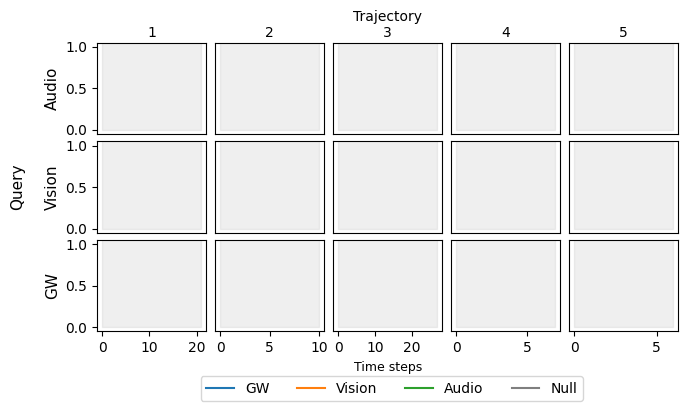

In [31]:
from matplotlib.ticker import MaxNLocator, MultipleLocator

colpal = sns.color_palette("tab10")
MOD_AXIS_TO_NAME = {0: "Audio", 1: "Vision", 2: r"Prev. state $h_{t-1}$", 3: "Null"}
MOD_AXIS_TO_COLOR = { 0: colpal[2], 1: colpal[1], 2: colpal[0], 3: colpal[7]}

# N_TRAJS = 4
mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use("ggplot")

TRAJS_OF_INTEREST_DICT = [
  *[{"category": "chair", "scene": "gTV8FGcVJC9", "traj_idx": i} for i in range(5)]
  # *[{"category": "picture", "scene": "gTV8FGcVJC9", "traj_idx": i} for i in range(5)] # No sound cutoffs 
  # *[{"category": "cushion", "scene": "gTV8FGcVJC9", "traj_idx": i} for i in range(5)]
  # *[{"category": "plant", "scene": "gTV8FGcVJC9", "traj_idx": i} for i in range(5)]
  # *[{"category": "cabinet", "scene": "gTV8FGcVJC9", "traj_idx": i} for i in range(5)]
  # *[{"category": "table", "scene": "gTV8FGcVJC9", "traj_idx": i} for i in range(5)]
]
N_TRAJS = len(TRAJS_OF_INTEREST_DICT)
fig, axes = plt.subplots(3, N_TRAJS, figsize=(N_TRAJS * 1.5, 3 * 1.25))


AGENT_GROUPS_OF_INTEREST = {
  # GW
  # "GW 32": {
  #   1: "ppo_bc__gw_32__seed_1",
  #   2: "ppo_bc__gw_32__seed_2",
  #   3: "ppo_bc__gw_32__seed_3",
  #   4: "ppo_bc__gw_32__seed_4",
  #   5: "ppo_bc__gw_32__seed_5",
  # },

  # "GW 64": {
  #   1: "ppo_bc__gw_64__seed_1",
  #   2: "ppo_bc__gw_64__seed_2",
  #   3: "ppo_bc__gw_64__seed_3",
  #   4: "ppo_bc__gw_64__seed_4",
  #   5: "ppo_bc__gw_64__seed_5",
  # },

  # "GW 128": {
  #   1: "ppo_bc__gw_128__seed_1",
  #   2: "ppo_bc__gw_128__seed_2",
  #   3: "ppo_bc__gw_128__seed_3",
  #   4: "ppo_bc__gw_128__seed_4",
  #   5: "ppo_bc__gw_128__seed_5",
  # },

  # "GW 256": {
  #   1: "ppo_bc__gw_256__seed_1",
  #   2: "ppo_bc__gw_256__seed_2",
  #   3: "ppo_bc__gw_256__seed_3",
  #   4: "ppo_bc__gw_256__seed_4",
  #   5: "ppo_bc__gw_256__seed_5",
  # },
  
  # "GW 512": {
  #   1: "ppo_bc__gw_512__seed_1",
  #   2: "ppo_bc__gw_512__seed_2",
  #   3: "ppo_bc__gw_512__seed_3",
  #   4: "ppo_bc__gw_512__seed_4",
  #   5: "ppo_bc__gw_512__seed_5",
  # },

  # GRU
  
}

# TODO: functionalize
for ridx in range(3):
  for cidx in range(N_TRAJS):
    # Tweak the ylimit for all plots
    axes[ridx, cidx].set_ylim(-0.05, 1.05)

    if ridx == 0:
      axes[ridx, cidx].xaxis.set_label_position("top")
      if cidx == 2:
        axes[ridx, cidx].set_xlabel(f"Trajectory\n{cidx+1}", fontsize=10)
      else:
        axes[ridx, cidx].set_xlabel(f"{cidx+1}", fontsize=10)
    if cidx > 0:
      axes[ridx, cidx].yaxis.set_major_locator(ticker.NullLocator())
    if ridx < 2:
      axes[ridx, cidx].xaxis.set_major_locator(ticker.NullLocator())
    else:
      axes[ridx, cidx].xaxis.set_major_locator(MaxNLocator(integer=True))
      if cidx == 2:
        axes[ridx, cidx].set_xlabel("Time steps", fontsize=9)

# Plots labelling
# ylabel_fontsize = 10
axes[0, 0].set_ylabel("Audio", fontsize=11)
axes[1, 0].set_ylabel("Query\n\nVision", fontsize=11)
axes[2, 0].set_ylabel("GW", fontsize=11)

# Create custom legend handles and labels
attn_weights_legend_handles = [
    Line2D([0], [0], color=colpal[color], label=label)
    for color, label in zip(
      [0, 1, 2, 7],
      ["GW", "Vision", "Audio", "Null"]
    )
]
bottom_row_x_MultipleLocator_bases = []

# Add legend
# plt.legend(handles=probe_acc_legend_handles)

# Iterate over traj data, plot if of interest
trajint_idx = 0

# TODO: rework the plotting to satisfy:
# 1. Iterate over the trajectories of interest
# 2. Group agent runs by seed, give them a name
for trajint_idx, trajint_data in enumerate(TRAJS_OF_INTEREST_DICT):
  cat = trajint_data["category"]
  scene = trajint_data["scene"]
  traj_idx = trajint_data["traj_idx"]

  # Load the current trajectory's data
  # TODO: could count this during the processing phase somehow ?
  obs_dict_list, _, _, _ = \
      get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, cat, scene, traj_idx, tensorize=False)
  
  T = len(CAT_SCENE_TRAJS_FEATURES[cat][scene][traj_idx]["target_category_idx_list"])

  if 0 < T <= 15:
    bottom_row_x_MultipleLocator_bases.append(5)
  elif T <= 50:
    bottom_row_x_MultipleLocator_bases.append(10)
  
  mute_step = 0
  spectrogram_obs_list = np.array([d["spectrogram"] for d in obs_dict_list])
  for t in range(T):
    if spectrogram_obs_list[t].sum() >= 1e-6:
      mute_step += 1
    else:
      break
  mute_step = min(mute_step, T-1)

  print(f"{cat} | {scene} | {traj_idx} | Length: {T}")

  # Plot the probe accuracies
  xs = np.arange(T)

  ## Shading the non silent region in gray
  [axes[i, trajint_idx].fill_between([0, mute_step+1], 0, [1.1, 1.1], color="gray", alpha=0.125) for i in [0, 1, 2]]
  
  for agent_group, agent_group_data in AGENT_GROUPS_OF_INTEREST.items():
    for exp_seed, exp_name in agent_group_data.items():

      ## Fix the length of the x axis
      [axes[i, trajint_idx].set_xlim([0, T-1]) for i in range(3)]

      if exp_name.__contains__("gw"):
        # Plot the attention weights for the GWTv3 variant
        att_weights = CAT_SCENE_TRAJS_FEATURES[cat][scene][traj_idx][exp_name]["state_encoder.ca.mha"][1][:, 0, :, :]

        for mod_idx in range(3):
          for mod_axis in range(4):
            mod_idx_offset = mod_idx-2
            axes[mod_idx, trajint_idx].plot(xs, att_weights[:, mod_idx_offset, mod_axis], 
              linewidth=1.25,
              label=MOD_AXIS_TO_NAME[mod_axis],
              color=MOD_AXIS_TO_COLOR[mod_axis],
              alpha=0.7)

# Set legend using dashed lines before doing the dots / scater
# axes[0, 0].legend(handles=probe_acc_legend_handles)
# axes[2, N_TRAJS-1].legend(handles=attn_weights_legend_handles)
# axes[2, 3].legend(handles=attn_weights_legend_handles, ncol=len(attn_weights_legend_handles), bbox_to_anchor=(0,0))
for cidx in range(len(TRAJS_OF_INTEREST_DICT)):
  axes[2, cidx].xaxis.set_major_locator(MultipleLocator(base=bottom_row_x_MultipleLocator_bases[cidx]))
  if cidx == 2:
      axes[1, cidx].set_xlabel("Time steps")

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.legend(handles=attn_weights_legend_handles, ncol=len(attn_weights_legend_handles), bbox_to_anchor=(0.782, 0.01))
# fig.supxlabel("Trajectory", va="top")
# fig.supylabel("Query", ha=)
# fig.tight_layout()
# fig.show()
plt.show()
# fig.savefig("tmpfig.pdf", bbox_inches="tight")
# fig.savefig("GW_32_Seed_1_AttentionWeights.pdf", bbox_inches="tight")
# fig.savefig("GW_32_Seed_1_2_3_4_5_AttentionWeights.pdf", bbox_inches="tight")

# fig.savefig("GW_64_Seed_1_AttentionWeights.pdf", bbox_inches="tight")
# fig.savefig("GW_64_Seed_2_AttentionWeights.pdf", bbox_inches="tight")
# fig.savefig("GW_64_Seed_1_2_3_4_5_AttentionWeights.pdf", bbox_inches="tight")

# fig.savefig("GW_128_Seed_1_AttentionWeights.pdf", bbox_inches="tight")
# fig.savefig("GW_128_Seed_1_2_3_4_5_AttentionWeights.pdf", bbox_inches="tight")

# fig.savefig("GW_256_Seed_1_AttentionWeights.pdf", bbox_inches="tight")
# fig.savefig("GW_256_Seed_1_2_3_4_5_AttentionWeights.pdf", bbox_inches="tight")

# fig.savefig("GW_512_Seed_1_AttentionWeights.pdf", bbox_inches="tight")
# fig.savefig("GW_512_Seed_1_2_3_4_5_AttentionWeights.pdf", bbox_inches="tight")


# Commands for the first submission
# fig.savefig("GWAgent_H_64_Seed_111_AttentionWeights.pdf", bbox_inches="tight")
# fig.savefig("GWAgent_H_64_Seed_222_AttentionWeights.pdf", bbox_inches="tight")

# fig.savefig("GWAgent_H_512_Seed_111_AttentionWeights.pdf", bbox_inches="tight")
# fig.savefig("GWAgent_H_512_Seed_222_AttentionWeights.pdf", bbox_inches="tight")

# Probing

In [63]:
# Loading the probe data
# Scene list for probe target label generation
SCENES = list(dataset_statistics["scene_counts"].keys())
CATEGORIES = list(dataset_statistics["category_counts"].keys())

N_SCENES = len(SCENES)
N_CATEGORIES = len(CATEGORIES)

# Old
# VIS_LAST_M_FRAMES = 3 # 3
# AUD_FRST_N_FRAMES = 9 # 10
# New
VIS_LAST_M_FRAMES = 0
AUD_FRST_N_FRAMES = 0 # 10

# NOTE: AGENTS_OF_INTEREST inherited from the RSA ablation feature computations

# Define the target of probing
## "category" -> how easy to predict category based on the learned features / inputs
## "scene" -> how easy to predict scene based on the learned features / inputs
PROBING_TARGETS = {}
for probe_target in args.probing_targets:
  if probe_target == "category":
    PROBING_TARGETS["category"] = {}
    PROBING_TARGETS["category"]["n_classes"] = N_CATEGORIES
  elif probe_target == "scene":
    PROBING_TARGETS["scene"] = {}
    PROBING_TARGETS["scene"]["n_classes"] = N_SCENES

# Class for a generic linear probe network
class GenericProbeNetwork(nn.Module):
  def __init__(self, name, input_dim, output_dim, depth=1, hid_size=512, bias=False):
    super().__init__()
    self.name = name
    assert depth >= 1, "Probe not deep enough: {depth}"
        
    hiddens = [hid_size for _ in range(depth)]
    network = []
    for h0, h1 in zip([input_dim, *hiddens[:-1]], [*hiddens[1:], output_dim]):
        network.append(nn.Linear(h0, h1, bias=bias))
        network.append(nn.ReLU())
    network.pop()
        
    self.network = nn.Sequential(*network)
    
  def forward(self, x):
      return self.network(x)

CAT_SCENE_TRAJ_PROBING_RESULTS = {
  cat: {
    scene: {
      traj_idx: {
        agent: {
          probe_target_name: {

          } for probe_target_name in ["category", "scene"]
        } for agent, _ in traj_dict.items() if agent not in ["target_scene_idx_list", "target_category_idx_list"]
        # } for agent in traj_dict
      } for traj_idx, traj_dict in scene_dict.items()
    } for scene, scene_dict in cat_dict.items()
  } for cat, cat_dict in CAT_SCENE_TRAJS_FEATURES.items()
}

OH_EYE_MAP = {
  "category": np.eye(21),
  "scene": np.eye(56)
}

# Accumulate probs for correct classification across "all" trajectories
# for summarized stats about the quality of the features.
# Define which fields of an agent to use for the probes
PROBING_INPUTS = ["state_encoder", "visual_encoder.rnn", "audio_encoder.rnn"]
ALL_TRAJ_PROBING_STATS = {}

print("## Generating probe networks for agents")
for cat, cat_dict in CAT_SCENE_TRAJS_FEATURES.items():
    print(f"  {cat}")
    for scene, scene_dict in cat_dict.items():
        print(f"    {scene}")
        for traj_idx, traj_dict in scene_dict.items():
            T = len(traj_dict["target_category_idx_list"])
            print(f"      Traj: {traj_idx}; Length: {T}")

            any_agent = list(traj_dict.keys())[0]

            aud_frst_n_frames = AUD_FRST_N_FRAMES if AUD_FRST_N_FRAMES else T
            vis_last_m_frames = VIS_LAST_M_FRAMES if VIS_LAST_M_FRAMES else T

            for agent_name, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
                if agent_name not in AGENTS_OF_INTEREST:
                    continue
                print(f"        Agent: {agent_name}")
                
                if agent_name not in ALL_TRAJ_PROBING_STATS.keys():
                    ALL_TRAJ_PROBING_STATS[agent_name] = {}
                
                # Instantiating probes
                PROBES_METADATA = {}
                for probe_target_name, probe_target_info in PROBING_TARGETS.items():
                    if probe_target_name not in ALL_TRAJ_PROBING_STATS[agent_name].keys():
                        ALL_TRAJ_PROBING_STATS[agent_name][probe_target_name] = {}

                    if probe_target_name not in PROBES_METADATA.keys():
                        PROBES_METADATA[probe_target_name] = {}
                    
                    for probe_input in PROBING_INPUTS: # NOTE: maybe switch order with the MODEL_VARIANTS ???

                        if probe_input not in PROBES_METADATA[probe_target_name].keys():
                            PROBES_METADATA[probe_target_name][probe_input] = {}

                        if probe_input == "state_encoder":
                            probe_input_dim = REVISED_RUNS_DICT[agent_name]["gw_size"]
                        else:
                            probe_input_dim = args.hidden_size
                        PROBES_METADATA[probe_target_name][probe_input]["probe_input_dim"] = probe_input_dim
                        PROBES_METADATA[probe_target_name][probe_input]["probe_output_dim"] = probe_target_info["n_classes"]

                    # Dictionary that will holds the probe networks and their optimizers
                    # PROBES = copy.copy(PROBES_METADATA)
                    for probe_input in PROBING_INPUTS: # NOTE: maybe switch order with the MODEL_VARIANTS ???
                        if probe_input not in ALL_TRAJ_PROBING_STATS[agent_name][probe_target_name].keys():
                            ALL_TRAJ_PROBING_STATS[agent_name][probe_target_name][probe_input] = []
                        
                        print(f"          {probe_target_name}|{probe_input}")
                        probe_name = f"{probe_target_name} | {probe_input}"
                        probe_input_dim = PROBES_METADATA[probe_target_name][probe_input]["probe_input_dim"]
                        probe_output_dim = PROBES_METADATA[probe_target_name][probe_input]["probe_output_dim"]

                        probe_network = GenericProbeNetwork(name=probe_name,
                                                            input_dim=probe_input_dim, 
                                                            output_dim=probe_output_dim,
                                                            depth=args.probe_depth,
                                                            hid_size=args.probe_hid_size,
                                                            bias=args.probe_bias).to(dev)

                        # Load the trained weights of the probe
                        probe_weight_savepath = f"{MODEL_VARIANTS_TO_STATEDICT_PATH[agent_name]['probe_path']}/models/{probe_target_name}__{probe_input}__probe.pth"
                        # print(f"  Probe save weights: {os.path.exists(probe_weight_savepath)}")

                        if agent_name in ["ppo_gru__random", "ppo_pgwt__random"]:
                            probe_state_dict = th.load(probe_weight_savepath)() # TODO: retrain proper ppo_XXX_random baseline that store the state dict instead of fn..
                        else:
                            probe_state_dict = th.load(probe_weight_savepath)
                        probe_network.load_state_dict(probe_state_dict)

                        probe_targets = traj_dict[{
                            "category": "target_category_idx_list",
                            "scene": "target_scene_idx_list"
                        }[probe_target_name]]
                        probe_targets = th.LongTensor(probe_targets)
                        
                        # print(traj_dict.keys())
                        features = traj_dict[agent_name][probe_input]
                        if len(features) == 2 and probe_input == "state_encoder":
                            features = features[0]
                        # Get traj features correponding toe "default" ablation
                        # which is just iterating over observations following
                        # the default setting of the agent training, no actual ablation
                        features = features[:, 0, :]
                        # print(f"    {features.shape}")
                        with th.no_grad():
                            probe_logits = probe_network(features.to(dev))
                        probe_probs = F.softmax(probe_logits, dim=-1)
                        predicted_idxes = probe_probs.argmax(dim=1).cpu().numpy()
                        predicted_idxes_oh = [OH_EYE_MAP[probe_target_name][cidx] for cidx in predicted_idxes]
                        
                        correct_idxes = probe_targets.int().tolist()
                        correct_idxes_oh = [OH_EYE_MAP[probe_target_name][cidx] for cidx in correct_idxes]

                        # TODO: optim over here desirable
                        if probe_target_name == "category":
                            correct_class_ids = [get_category_name(cidx) for cidx in correct_idxes]
                            predicted_class_ids = [get_category_name(cidx) for cidx in predicted_idxes]
                        elif probe_target_name == "scene":
                            correct_class_ids = [get_sceneid_by_idx(cidx) for cidx in correct_idxes]
                            predicted_class_ids = [get_sceneid_by_idx(cidx) for cidx in predicted_idxes]
                        else:
                            raise NotImplementedError(f"Unsuported probe_target_name: {probe_target_name}")

                        # print(correct_class_ids)
                        # print(predicted_class_ids)
                        # print(f"    {probe_logits.shape} | {probe_probs.sum(dim=-1).sum()}")
                        # print(f"    {probe_targets.shape}")

                        # Compat between version with and without SSL task rec-rgb-vis-ae-5
                        
                        CAT_SCENE_TRAJ_PROBING_RESULTS[cat][scene][traj_idx][agent_name][probe_target_name][probe_input] = {
                            "probs": probe_probs.cpu().numpy(),
                            
                            "correct_idxes": correct_idxes,
                            "predicted_idxes": predicted_idxes,
                            
                            "correct_class_ids": correct_class_ids,
                            "predicted_class_ids": predicted_class_ids,
                            
                            "correct_idxes_oh": correct_idxes_oh,
                            "predicted_idxes_oh": predicted_idxes_oh
                        }

                        # Accumuluting stats for overview metrics
                        success_rate = correct_idxes == predicted_idxes
                        # correct_idxes_probs = [pv[ix].item() for ix, pv in zip(correct_idxes, probe_probs)] # Predicted probablities at ground truth's index
                        if probe_target_name == "category":
                            if probe_input in ["visual_encoder.rnn"]:
                                # When probing "category" based on visual feats, only the LAST_M_FRAMES
                                # are considered relevant
                                # correct_idxes_probs = correct_idxes_probs[-vis_last_m_frames:]
                                # success_rate = correct_idxes[-vis_last_m_frames:] == predicted_idxes[-vis_last_m_frames:]
                                success_rate = correct_idxes == predicted_idxes
                            elif probe_input in ["audio_encoder.rnn"]:
                                # WHen probing "category" based on audio feats, only the FRST_N_FRAMES
                                # are considered relevant
                                # correct_idxes_probs = correct_idxes_probs[:aud_frst_n_frames]
                                # success_rate = correct_idxes[:aud_frst_n_frames] == predicted_idxes[:aud_frst_n_frames]
                                success_rate = correct_idxes == predicted_idxes

                        ALL_TRAJ_PROBING_STATS[agent_name][probe_target_name][probe_input].extend(
                            success_rate)
                    
                    print("")


# CAT_SCENE_TRAJ_PROBING_RESULTS

## Generating probe networks for agents
  chair
    gTV8FGcVJC9
      Traj: 0; Length: 28
        Agent: ppo_bc__gw_32__seed_1
          category|state_encoder
          category|visual_encoder.rnn
          category|audio_encoder.rnn

          scene|state_encoder
          scene|visual_encoder.rnn
          scene|audio_encoder.rnn

        Agent: ppo_bc__gw_64__seed_1
          category|state_encoder
          category|visual_encoder.rnn
          category|audio_encoder.rnn

          scene|state_encoder
          scene|visual_encoder.rnn
          scene|audio_encoder.rnn

        Agent: ppo_bc__gw_128__seed_1
          category|state_encoder
          category|visual_encoder.rnn
          category|audio_encoder.rnn

          scene|state_encoder
          scene|visual_encoder.rnn
          scene|audio_encoder.rnn

        Agent: ppo_bc__gw_256__seed_1
          category|state_encoder
          category|visual_encoder.rnn
          category|audio_encoder.rnn

          scene|state_en

In [64]:
# Filtering out runs for the overview plot of the probing accuracies
AGENTS_OF_INTEREST__PROBING_OVERVIEW = [
    # GW
    ## GW 32
    # "ppo_bc__gw_32__seed_1",
    # "ppo_bc__gw_32__seed_2",
    # "ppo_bc__gw_32__seed_3",
    # "ppo_bc__gw_32__seed_4",
    # "ppo_bc__gw_32__seed_5",

    ## GW 64
    # "ppo_bc__gw_64__seed_1",
    # "ppo_bc__gw_64__seed_2",
    # "ppo_bc__gw_64__seed_3",
    # "ppo_bc__gw_64__seed_4",
    # "ppo_bc__gw_64__seed_5",

    ## GW 128
    "ppo_bc__gw_128__seed_1",
    "ppo_bc__gw_128__seed_2",
    "ppo_bc__gw_128__seed_3",
    "ppo_bc__gw_128__seed_4",
    "ppo_bc__gw_128__seed_5",

    ## GW 256
    # "ppo_bc__gw_256__seed_1",
    # "ppo_bc__gw_256__seed_2",
    # "ppo_bc__gw_256__seed_3",
    # "ppo_bc__gw_256__seed_4",
    # "ppo_bc__gw_256__seed_5",

    ## GW 512
    # "ppo_bc__gw_512__seed_1",
    # "ppo_bc__gw_512__seed_2",
    # "ppo_bc__gw_512__seed_3",
    # "ppo_bc__gw_512__seed_4",
    # "ppo_bc__gw_512__seed_5",


    # GRU
    ## GRU 32
    # "ppo_bc__gru_32__seed_1",
    # "ppo_bc__gru_32__seed_2",
    # "ppo_bc__gru_32__seed_3",
    # "ppo_bc__gru_32__seed_4",
    # "ppo_bc__gru_32__seed_5",

    ## GRU 64
    # "ppo_bc__gru_64__seed_1",
    # "ppo_bc__gru_64__seed_2",
    # "ppo_bc__gru_64__seed_3",
    # "ppo_bc__gru_64__seed_4",
    # "ppo_bc__gru_64__seed_5",

    ## GRU 128
    "ppo_bc__gru_128__seed_1",
    "ppo_bc__gru_128__seed_2",
    "ppo_bc__gru_128__seed_3",
    "ppo_bc__gru_128__seed_4",
    "ppo_bc__gru_128__seed_5",

    ## GRU 256
    # "ppo_bc__gru_256__seed_1",
    # "ppo_bc__gru_256__seed_2",
    # "ppo_bc__gru_256__seed_3",
    # "ppo_bc__gru_256__seed_4",
    # "ppo_bc__gru_256__seed_5",

    ## GRU 512
    # "ppo_bc__gru_512__seed_1",
    # "ppo_bc__gru_512__seed_2",
    # "ppo_bc__gru_512__seed_3",
    # "ppo_bc__gru_512__seed_4",
    # "ppo_bc__gru_512__seed_5",
]

agent_list = [a for a in ALL_TRAJ_PROBING_STATS.keys() if a in AGENTS_OF_INTEREST__PROBING_OVERVIEW] # For plotting of probing accuracies

AGENTNAME_TO_PRETTYNAME = {k: REVISED_RUNS_DICT[k]["pretty_name"] for k in AGENTS_OF_INTEREST__PROBING_OVERVIEW}; AGENTNAME_TO_PRETTYNAME

{'ppo_bc__gw_128__seed_1': 'GW 128 [1]',
 'ppo_bc__gw_128__seed_2': 'GW 128 [2]',
 'ppo_bc__gw_128__seed_3': 'GW 128 [3]',
 'ppo_bc__gw_128__seed_4': 'GW 128 [4]',
 'ppo_bc__gw_128__seed_5': 'GW 128 [5]',
 'ppo_bc__gru_128__seed_1': 'GRU 128 [1]',
 'ppo_bc__gru_128__seed_2': 'GRU 128 [2]',
 'ppo_bc__gru_128__seed_3': 'GRU 128 [3]',
 'ppo_bc__gru_128__seed_4': 'GRU 128 [4]',
 'ppo_bc__gru_128__seed_5': 'GRU 128 [5]'}

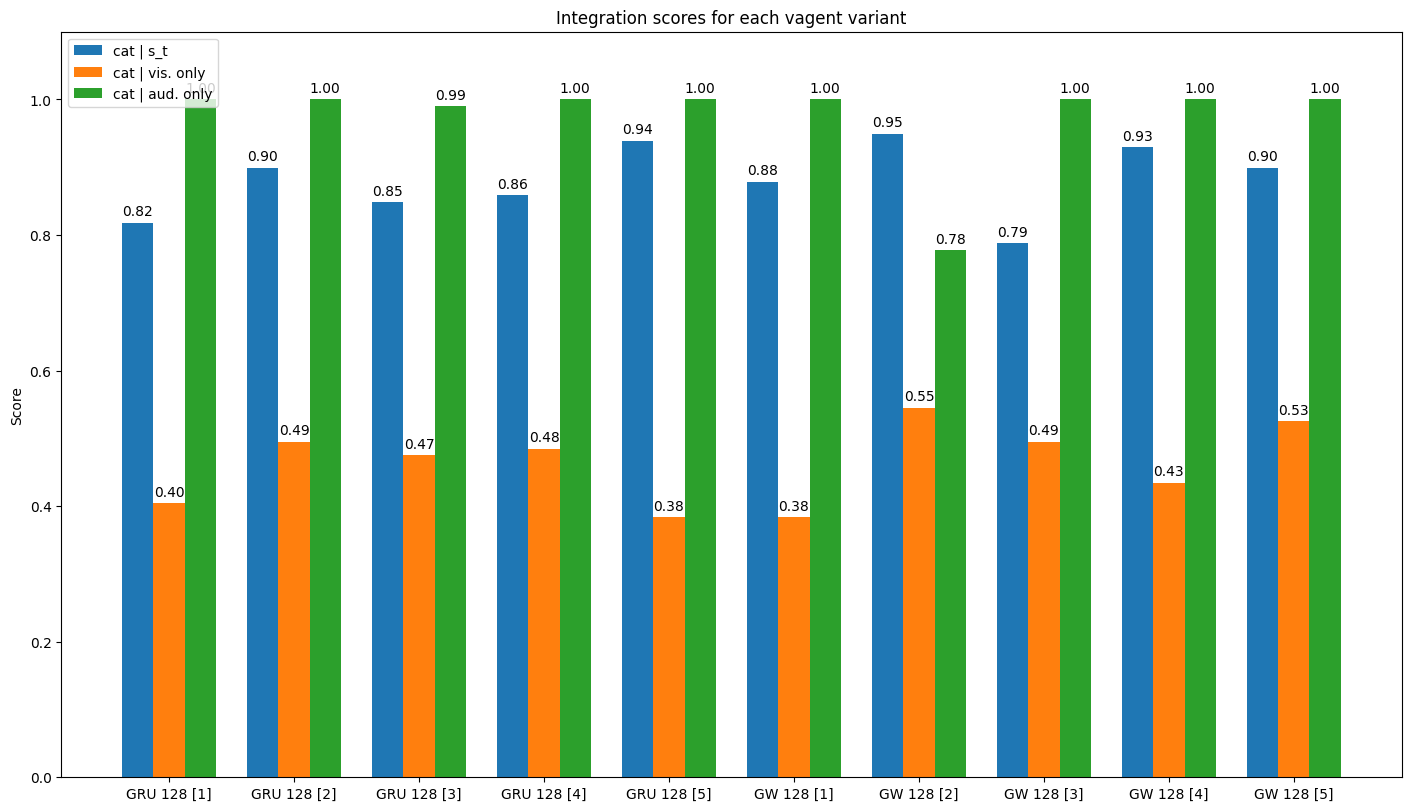

In [65]:
fig, ax = plt.subplots(1,1, figsize=(14,8), layout="constrained")

probe_stats_means__cat = {
    "cat | s_t": [np.mean(
        ALL_TRAJ_PROBING_STATS[agentname]["category"]["state_encoder"]
    ) for agentname in agent_list],

    # cat
    "cat | vis. only": [np.mean(ALL_TRAJ_PROBING_STATS[agentname]["category"]["visual_encoder.rnn"])
        for agentname in agent_list],
    "cat | aud. only": [np.mean(ALL_TRAJ_PROBING_STATS[agentname]["category"]["audio_encoder.rnn"])
        for agentname in agent_list],
}

x = np.arange(len(agent_list))
# width = 0.25
width = 1.0 / (len(list(probe_stats_means__cat.keys()))+1)
multiplier = 0

for attribute, measurement in probe_stats_means__cat.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt="%.2f")
    multiplier +=1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Integration scores for each vagent variant')
ax.set_xticks(x + width, [AGENTNAME_TO_PRETTYNAME[name] for name in sorted(agent_list)])
ax.legend(loc='upper left')#, ncol=len(probe_stats_means__cat.keys()))
ax.set_ylim(0, 1.1)

plt.show()

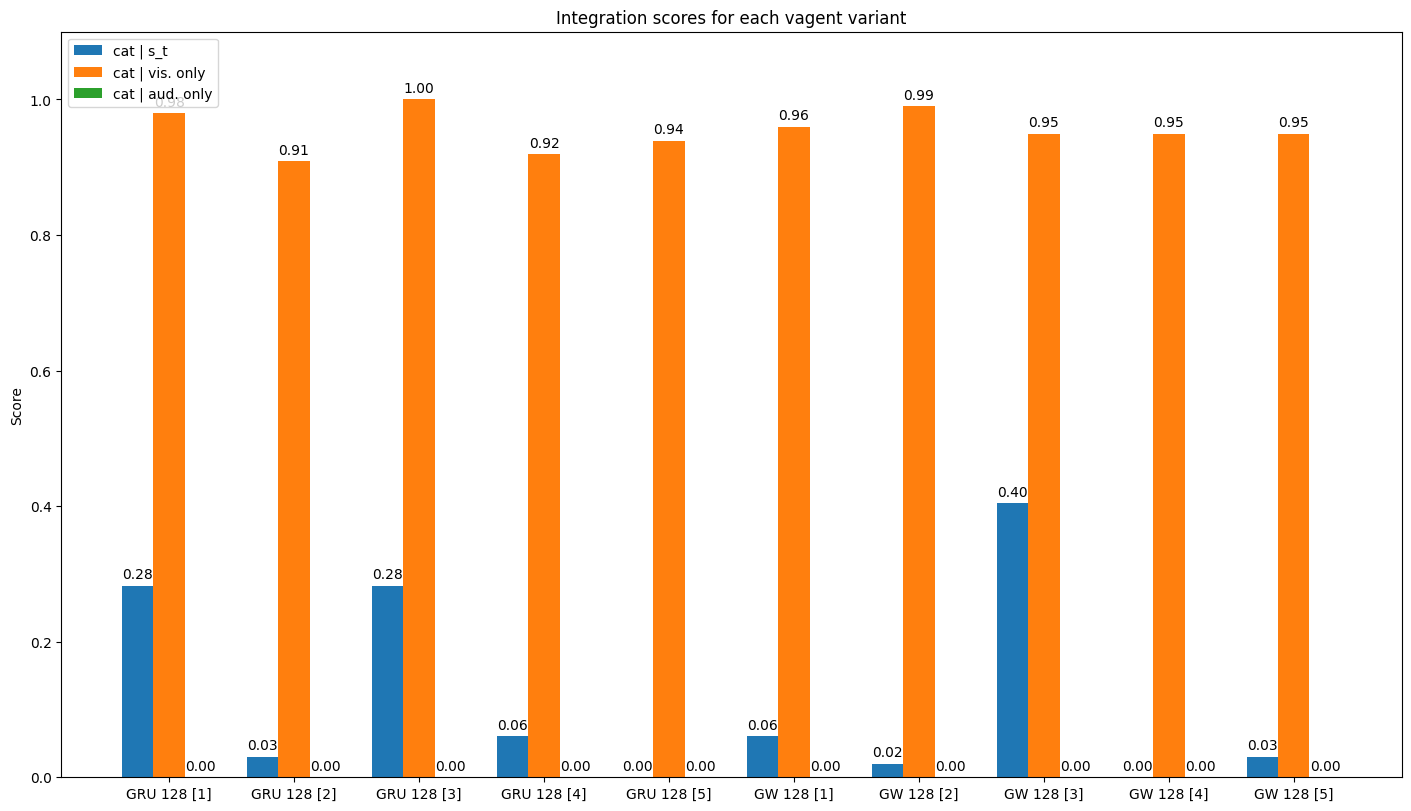

In [66]:
fig, ax = plt.subplots(1,1, figsize=(14,8), layout="constrained")

probe_stats_means__cat = {
    "cat | s_t": [np.mean(
        ALL_TRAJ_PROBING_STATS[agentname]["scene"]["state_encoder"]
    ) for agentname in agent_list],

    # cat
    "cat | vis. only": [np.mean(ALL_TRAJ_PROBING_STATS[agentname]["scene"]["visual_encoder.rnn"])
        for agentname in agent_list],
    "cat | aud. only": [np.mean(ALL_TRAJ_PROBING_STATS[agentname]["scene"]["audio_encoder.rnn"])
        for agentname in agent_list],
}

x = np.arange(len(agent_list))
# width = 0.25
width = 1.0 / (len(list(probe_stats_means__cat.keys()))+1)
multiplier = 0

for attribute, measurement in probe_stats_means__cat.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fmt="%.2f")
    multiplier +=1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Integration scores for each vagent variant')
ax.set_xticks(x + width, [AGENTNAME_TO_PRETTYNAME[name] for name in sorted(agent_list)])
ax.legend(loc='upper left')#, ncol=len(probe_stats_means__cat.keys()))
ax.set_ylim(0, 1.1)

plt.show()